## Executive Summary

Idea: 
The weekend of the 13th of December, 2024 was a very interesting one for Nigerians; with three movies from some of the most revered actors/producers being released for public viewing – Everybody Loves Jenifa (ELJ), Seven Doors and Thin Line, and jostling for the usually short-attention span of viewers.

Objective:
To assess the pulse of Twitter engagements, leading up to the release of these movies, on the day of the release for general viewing, and the few days after.

Findings:
- ELJ was big on campaign, and the bulk of Twitter engagement on 8th December, 2024 revolved around commentary on outfits worn to the premiere.
- Seven Doors (like the queen who is never late) did not have significant engagement leading up to its release, but led conversations on 13th of December, 2024. Most of these engagements related to the plot, characters, and actors.
- Thin Line was the thin line between ELJ and Seven Doors. Engagement was at its peak on the two days following its initial premiere on the 10th of December, 2024; and most of this also related to commentary on outfits worn to the premiere.
- Sentiment and Emotion
- Overall sentiment for both movies was positive, relating to joy and excitement over user’s favorite characters, actors and role models.

In [52]:
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from random import randint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import ast
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

## Read Data and Preprocess

In [2]:
# Read data and maximize column text width
movies = pd.read_csv('top_13dec24_movies.csv')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Format the timestamp to show just the day, month, and year
movies['Time_of_Creation'] = pd.to_datetime(movies['Time_of_Creation'], format='%a %b %d %H:%M:%S +0000 %Y')

# Extract day, month, and year in the desired format
movies['Date'] = pd.to_datetime(movies['Time_of_Creation'].dt.strftime('%d-%b-%Y'))

# Drop the original timestamp column since we no longer need it
movies = movies.drop('Time_of_Creation', axis=1)

# Ensure the 'Hashtags' column contains Python lists, which makes our analysis easier
movies['Hashtags'] = movies['Hashtags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert all hashtags to lowercase
movies['Hashtags'] = movies['Hashtags'].apply(lambda hashtags: [tag.lower() for tag in hashtags])

movies.head(2)

,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date
0,1,I’m up and grateful to God!! It’s my birthday!!💃🏽💃🏽💃🏽 #everybodylovesjenifa https://t.co/VoGAaPClsc,[everybodylovesjenifa],2176,29431,2024-08-24
1,2,After singing “ my husband does not have a concubine” only for your husband to marry 6 more wives 😭😭😂😂\nI knew something would happen after she sang that song \n#SevenDoors https://t.co/he4Bx81T4X,[sevendoors],0,2,2024-12-17


In [3]:
movies.shape

(970, 6)

Remove irrelevant words that may derail the sentiment analysis, by virtue of mis-use of hashtags.

In [4]:
# Define irrelevant keywords/phrases
irrelevant_keywords = ["opay", "mbappe", "osimhen", "rema", "loan", "monday", "morning", "mondaymorning", "shiloh", "link in my bio", "like and retweet", "giveaway", "win a prize", "naira marley", "verydarkman", "arsenal", "chelsea", "burna", "atiku", "n50m", "jamb", "kemi", "kemi badenoch", "nationwide delivery", "portable", "send a dm", "dm", "products", "product", "national grid", "bob risky", "wizkid", "kese", "jarvis", "lagbaja", "lungu", "wiki", "nairamaley"]

irrelevant_tweet = movies[movies['Tweet'].str.contains('|'.join(irrelevant_keywords), case=False)]

# Filter tweets that contain irrelevant keywords
movies = movies[~movies['Tweet'].str.contains('|'.join(irrelevant_keywords), case=False)]

irrelevant_tweet.shape

(128, 6)

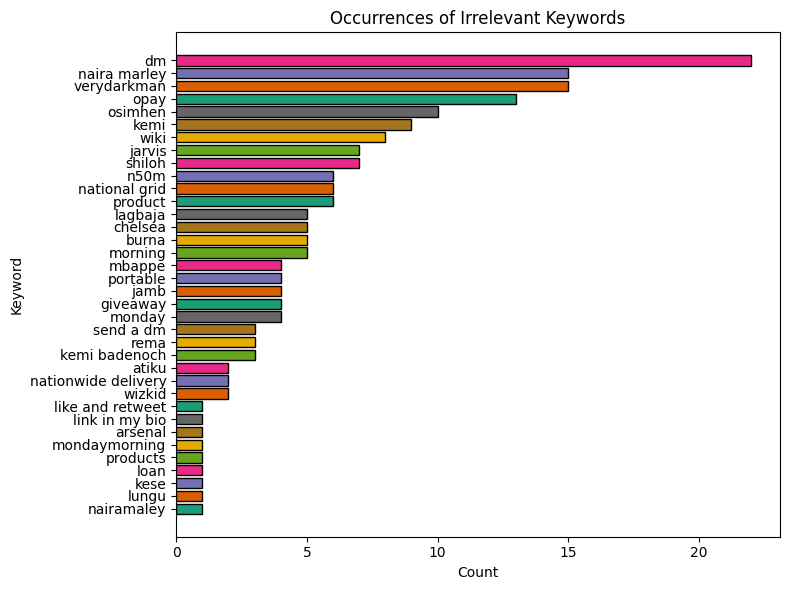

In [5]:
# Count occurrences of each keyword in the DataFrame
irrelevant_tweet_counts = {word: irrelevant_tweet['Tweet'].str.contains(word, case=False, na=False).sum() for word in irrelevant_keywords}

# Convert counts to a DataFrame
irrelevant_tweet_counts_df = pd.DataFrame(list(irrelevant_tweet_counts.items()), columns=['Keyword', 'Count'])
irrelevant_tweet_counts_df = irrelevant_tweet_counts_df[irrelevant_tweet_counts_df['Count'] > 0]  # Filter out keywords with 0 counts
irrelevant_tweet_counts_df = irrelevant_tweet_counts_df.sort_values(by='Count', ascending=True)

colors = sns.color_palette('Dark2')

# Visualize the counts with a bar chart
plt.figure(figsize=(8, 6))
plt.barh(irrelevant_tweet_counts_df['Keyword'], irrelevant_tweet_counts_df['Count'], color=colors, edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Occurrences of Irrelevant Keywords')
plt.tight_layout()
plt.show()

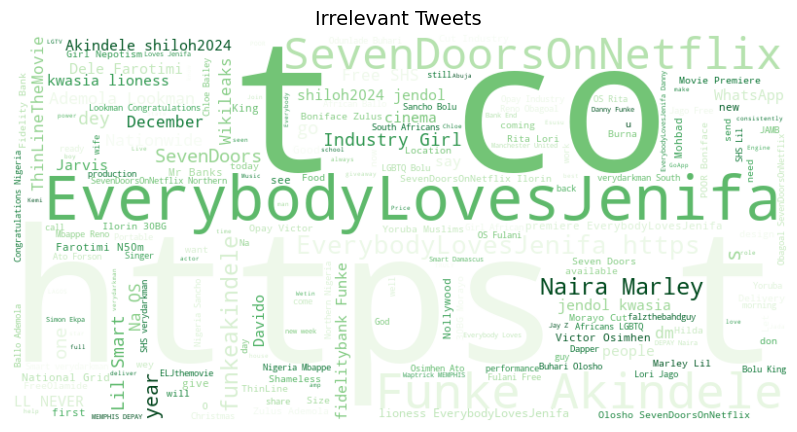

In [6]:
# Filter tweets by irrelevant keywords
irrelevant_tweets = ' '.join(irrelevant_tweet['Tweet'])

custom_stopwords = set(STOPWORDS)

# Generate word clouds
irrelevant_tweets_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens', stopwords=custom_stopwords).generate(irrelevant_tweets)

# Plot word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(irrelevant_tweets_wc, interpolation='bilinear')
plt.title('Irrelevant Tweets', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

To easily identify which movie each hashtag or tweet relates to, I will eliminate rows that may contain multiple hashtags relating to all three movies being reviewed, and create a new column to show the specific movie each retained tweet relates to.

In [7]:
# Keywords to check for
keywords = ['sevendoors', 'thinline', 'everybodylovesjenifa', 'everyonelovesjenifa', 'elj']

# Helper function to check for variations and count matches
def match_keywords(hashtag_list):
    matches = [keyword for keyword in keywords if any(keyword in tag for tag in hashtag_list)]
    return matches

# Apply the function to get matches for each row
movies['Matches'] = movies['Hashtags'].apply(match_keywords)

# Count the number of matches
movies['Match_Count'] = movies['Matches'].apply(len)

# Drop rows with more than one match
movies = movies[movies['Match_Count'] <= 1]

# Create the 'Movie' column based on the first match (if any)
movies['Movie'] = movies['Matches'].apply(lambda x: x[0] if x else None)

# Drop intermediate columns if no longer needed
movies.drop(columns=['Matches', 'Match_Count'], inplace=True)
movies.head(2)

,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie
0,1,I’m up and grateful to God!! It’s my birthday!!💃🏽💃🏽💃🏽 #everybodylovesjenifa https://t.co/VoGAaPClsc,[everybodylovesjenifa],2176,29431,2024-08-24,everybodylovesjenifa
1,2,After singing “ my husband does not have a concubine” only for your husband to marry 6 more wives 😭😭😂😂\nI knew something would happen after she sang that song \n#SevenDoors https://t.co/he4Bx81T4X,[sevendoors],0,2,2024-12-17,sevendoors


In [8]:
movies.shape

(755, 7)

In [9]:
movie_counts = movies['Movie'].value_counts()
movie_counts

Movie
everybodylovesjenifa    371
sevendoors              293
thinline                 91
Name: count, dtype: int64

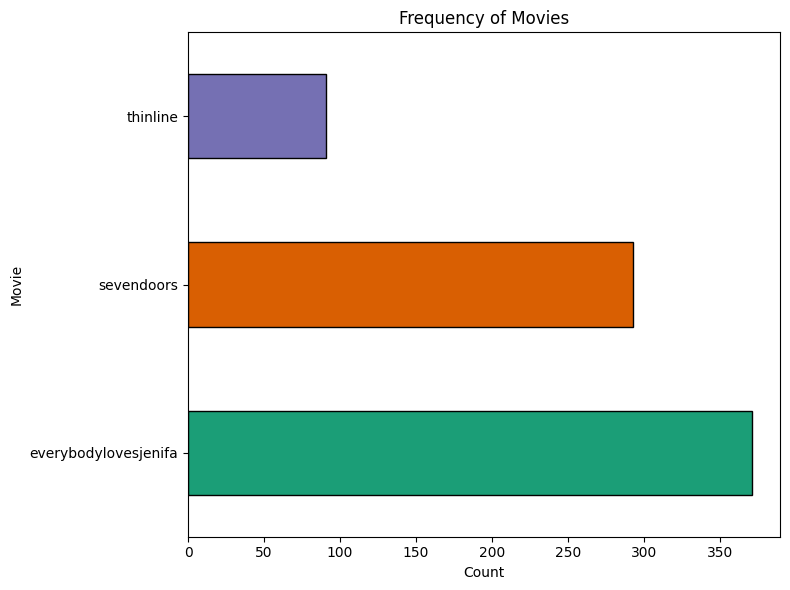

In [10]:
# Visualizing the Proportion of my Cleaned Data - Plot horizontal bar chart
plt.figure(figsize=(8, 6))
colors = sns.color_palette('Dark2')
movie_counts.plot(kind='barh', color=colors, edgecolor='black')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Movie')
plt.title('Frequency of Movies')

# Display the plot
plt.tight_layout()
plt.show()

## Data Exploration

In [11]:
# Find the range of dates
start_date = movies['Date'].min()
end_date = movies['Date'].max()

print(f"Date Range: {start_date} to {end_date}")

Date Range: 2024-08-24 00:00:00 to 2024-12-17 00:00:00


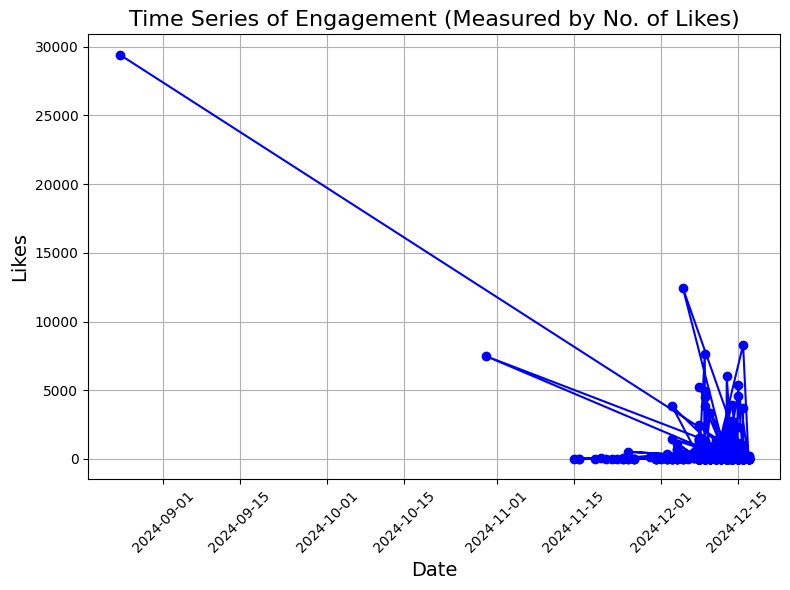

In [12]:
# Plot the time series
plt.figure(figsize=(8, 6))
plt.plot(movies['Date'], movies['Likes'], marker='o', linestyle='-', color='b')
plt.title("Time Series of Engagement (Measured by No. of Likes)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Likes", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

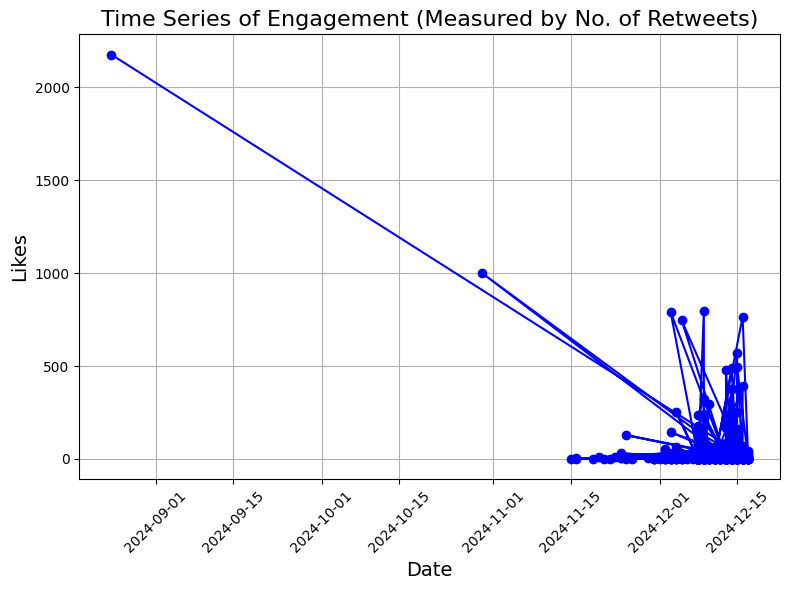

In [13]:
# Plot the time series
plt.figure(figsize=(8, 6))
plt.plot(movies['Date'], movies['Retweets'], marker='o', linestyle='-', color='b')
plt.title("Time Series of Engagement (Measured by No. of Retweets)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Likes", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

I'd like to examine the earliest data, since it has such high engagement.

In [14]:
earliest_data = movies[movies['Date'] < '2024-09-01']
earliest_data

,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie
0,1,I’m up and grateful to God!! It’s my birthday!!💃🏽💃🏽💃🏽 #everybodylovesjenifa https://t.co/VoGAaPClsc,[everybodylovesjenifa],2176,29431,2024-08-24,everybodylovesjenifa


Since the data is not useful to show engagement relating to the movie, #everybodylovesjenifa, I would eliminate it from the analysis data.

In [15]:
movies_to_analyse = movies.loc[movies['Date'] > '2024-09-01']

I want to analyse engagement on a date basis, to see how each movie performed accordingly.

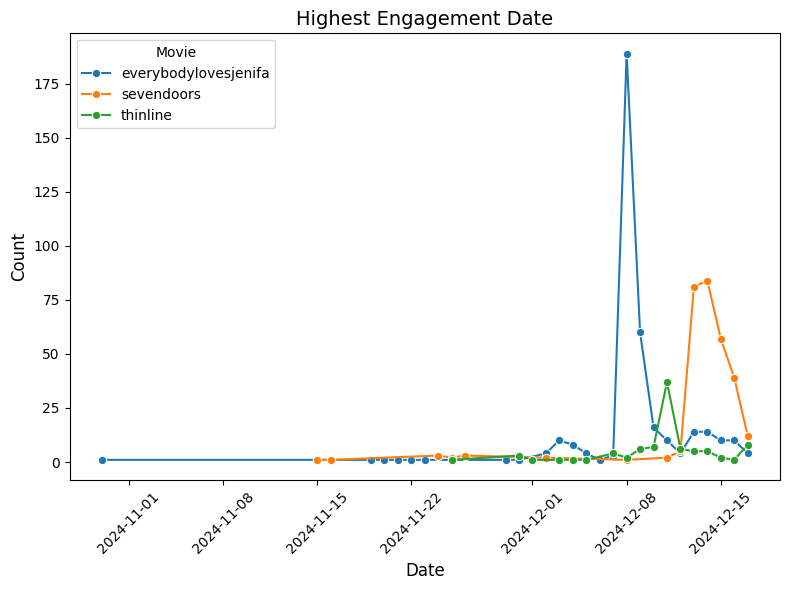

In [16]:
# Group by Date and Movie
highest_engagement_date = movies_to_analyse.groupby(['Date', 'Movie']).size().reset_index(name='Count')

# Create a line plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=highest_engagement_date, x='Date', y='Count', hue='Movie', marker='o')
plt.title('Highest Engagement Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Movie', fontsize=10)
plt.tight_layout()
plt.show()

In [17]:
movies_to_analyse['Date'].value_counts().head(10)

Date
2024-12-08    192
2024-12-14    103
2024-12-13    100
2024-12-15     69
2024-12-09     66
2024-12-16     50
2024-12-11     49
2024-12-17     24
2024-12-10     23
2024-12-12     15
Name: count, dtype: int64

In [18]:
movieson8th = movies_to_analyse[movies_to_analyse['Date'] == '2024-12-08']
movieson8th['Movie'].value_counts()

Movie
everybodylovesjenifa    189
thinline                  2
sevendoors                1
Name: count, dtype: int64

In [19]:
movieson14th = movies_to_analyse[movies_to_analyse['Date'] == '2024-12-14']
movieson14th['Movie'].value_counts()

Movie
sevendoors              84
everybodylovesjenifa    14
thinline                 5
Name: count, dtype: int64

In [20]:
movieson13th = movies_to_analyse[movies_to_analyse['Date'] == '2024-12-13']
movieson13th['Movie'].value_counts()

Movie
sevendoors              81
everybodylovesjenifa    14
thinline                 5
Name: count, dtype: int64

While the above analysis reveals that anticipation was significant for ELJ, the engagement post-release titlted in favor of SevenDoors.

I will split the data based on the release date, for further analysis.

In [21]:
release_date_cut_off = pd.Timestamp('2024-12-12') # to account for viewer's time difference
anticipation_data = movies_to_analyse.loc[movies['Date'] <= release_date_cut_off]
review_data = movies_to_analyse.loc[movies['Date'] > release_date_cut_off]

### Pre-Release

In [22]:
# Group by 'Movie' and calculate engagement metrics
engagement_summary_prerelease = anticipation_data.groupby('Movie').agg(
    Count=('Movie', 'size'),    # Count the number of rows for each movie
    Likes=('Likes', 'mean'),     # Total likes
    Retweets=('Retweets', 'mean')  # Total retweets
).reset_index()

# Check the grouped DataFrame
engagement_summary_prerelease

,Movie,Count,Likes,Retweets
0,everybodylovesjenifa,318,296.235849,25.154088
1,sevendoors,20,47.650000,11.700000
2,thinline,70,103.585714,7.757143


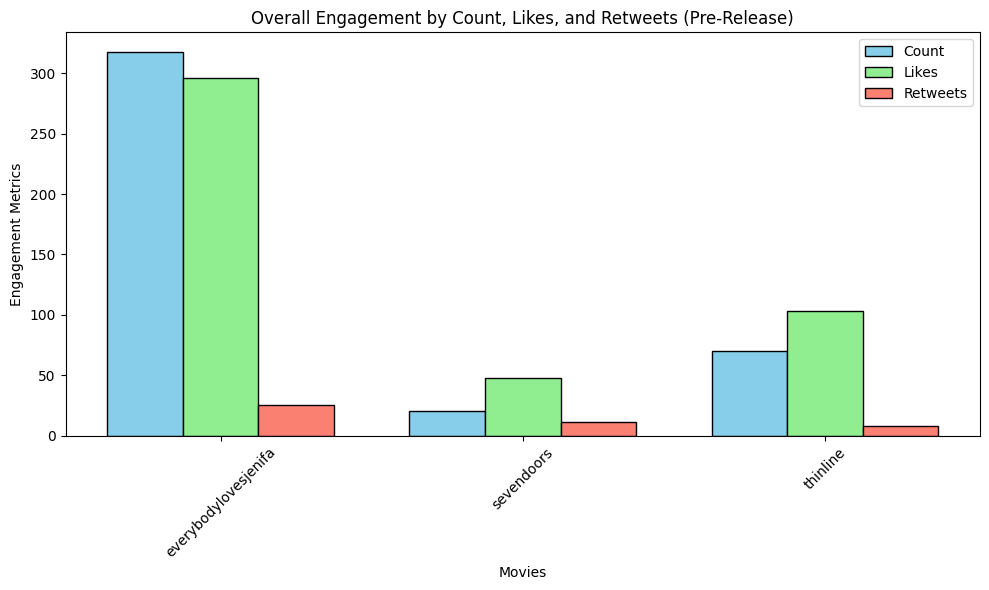

In [23]:
# Set up for grouped bar chart
bar_width = 0.25
index = range(len(engagement_summary_prerelease['Movie']))

plt.figure(figsize=(10, 6))

# Plot Count, Likes, and Retweets
plt.bar(index, engagement_summary_prerelease['Count'], bar_width, label='Count', color='skyblue', edgecolor='black')
plt.bar([i + bar_width for i in index], engagement_summary_prerelease['Likes'], bar_width, label='Likes', color='lightgreen', edgecolor='black')
plt.bar([i + 2*bar_width for i in index], engagement_summary_prerelease['Retweets'], bar_width, label='Retweets', color='salmon', edgecolor='black')

# Add labels and title
plt.xlabel('Movies')
plt.ylabel('Engagement Metrics')
plt.title('Overall Engagement by Count, Likes, and Retweets (Pre-Release)')
plt.xticks([i + bar_width for i in index], engagement_summary_prerelease['Movie'], rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

### Post-Release

In [24]:
# Group by 'Movie' and calculate engagement metrics
engagement_summary_postrelease = review_data.groupby('Movie').agg(
    Count=('Movie', 'size'),    # Count the number of rows for each movie
    Likes=('Likes', 'mean'),     # Total likes
    Retweets=('Retweets', 'mean')  # Total retweets
).reset_index()

# Check the grouped DataFrame
engagement_summary_postrelease

,Movie,Count,Likes,Retweets
0,everybodylovesjenifa,52,71.115385,8.846154
1,sevendoors,273,230.959707,24.684982
2,thinline,21,111.238095,28.095238


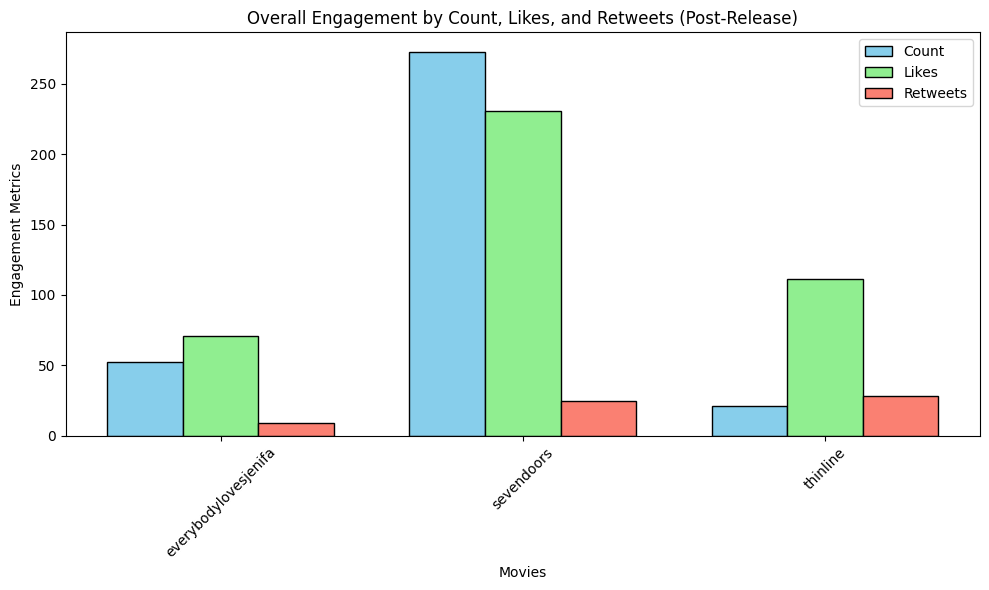

In [25]:
# Set up for grouped bar chart
bar_width = 0.25
index = range(len(engagement_summary_postrelease['Movie']))

plt.figure(figsize=(10, 6))

# Plot Count, Likes, and Retweets
plt.bar(index, engagement_summary_postrelease['Count'], bar_width, label='Count', color='skyblue', edgecolor='black')
plt.bar([i + bar_width for i in index], engagement_summary_postrelease['Likes'], bar_width, label='Likes', color='lightgreen', edgecolor='black')
plt.bar([i + 2*bar_width for i in index], engagement_summary_postrelease['Retweets'], bar_width, label='Retweets', color='salmon', edgecolor='black')

# Add labels and title
plt.xlabel('Movies')
plt.ylabel('Engagement Metrics')
plt.title('Overall Engagement by Count, Likes, and Retweets (Post-Release)')
plt.xticks([i + bar_width for i in index], engagement_summary_prerelease['Movie'], rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

### Analysis of Engagement Drivers

To find the top-words that may have driven engagement across these movies, I will pre-process the data to filter stop-words and other kinds of 'data-noise'.

In [26]:
processed_data = movies_to_analyse.copy()

def remove_emojis(text):
    # Extended Emoji pattern: Match Unicode ranges for emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons (😀 - 😏)
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs (🏀 - 🎮)
        "\U0001F680-\U0001F6FF"  # Transport & map symbols (🚀 - 🛶)
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS) (🇦 - 🇿)
        "\U00002702-\U000027B0"  # Dingbats (✂ - ➰)
        "\U000024C2-\U0001F251"  # Enclosed characters (Ⓜ - 🉑)
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs (🤐 - 🤿)
        "\U0001FA70-\U0001FAFF"  # Symbols & Pictographs Extended-A (🩰 - 🫿)
        "\U0001F004-\U0001F0CF"  # Mahjong and Playing Cards (🀄 - 🃏)
        "\U0001F18E"             # Negative Squared Latin Letters (🆎)
        "\U0001F191-\U0001F19A"  # Squared CL, COOL, FREE, ID, etc. (🆑 - 🆚)
        "\U0001F1F2-\U0001F1F4"  # Regional Indicator Symbols
        "\U0001F1F8-\U0001F1FD"  # Regional Indicator Symbols (continued)
        "\U00002600-\U000026FF"  # Miscellaneous Symbols (☀ - ⚡)
        "\U0001FA60-\U0001FA6D"  # Extended pictographs (🩠 - 🩭)
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

# Pre-process Data
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove URLs and mentions
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[\w]+', '', text)

    # Remove hashtags
    text = re.sub(r'#\S+', '', text)

    return text

# Apply pre-processing to the Tweet column
processed_data['Processed_Tweet'] = processed_data['Tweet'].apply(remove_emojis)
processed_data['Processed_Tweet'] = processed_data['Processed_Tweet'].apply(preprocess_text)

In [27]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the text column
tfidf_matrix = vectorizer.fit_transform(processed_data['Processed_Tweet'])

# Get feature names and sum TF-IDF scores
tfidf_scores = tfidf_matrix.sum(axis=0)
words_scores = [(word, tfidf_scores[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# Sort words by their TF-IDF scores
top_words = sorted(words_scores, key=lambda x: x[1], reverse=True)[:20]

# Extract words and their scores as a list of tuples
top_words_list = [(word, score) for word, score in top_words]

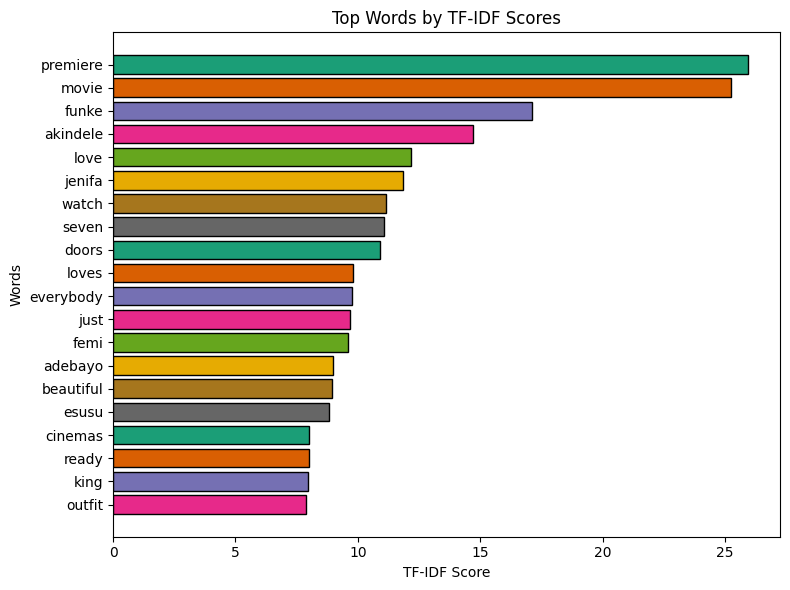

In [28]:
# Extract words and their scores
words, scores = zip(*top_words_list)

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.barh(words, scores, color=colors, edgecolor='black')

# Add labels and title
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.title('Top Words by TF-IDF Scores')

# Invert y-axis for better readability
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()

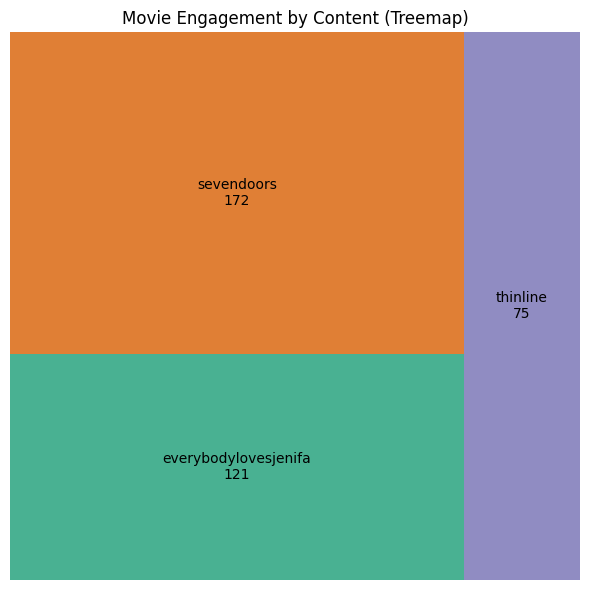

In [29]:
# Define top engagement drivers that are not overly generic (e.g., beautiful) or associated with name of actor or title of movie
engagement_drivers_content_list = ["watch", "esusu", "king", "movie", "just", "don"]
engagement_drivers_content = movies_to_analyse[movies_to_analyse['Tweet'].str.contains('|'.join(engagement_drivers_content_list), case=False)]

# Prepare data
engagement_driven_by_content = engagement_drivers_content.groupby('Movie').size()
sizes = engagement_driven_by_content.values
labels = [f"{movie}\n{count}" for movie, count in zip(engagement_driven_by_content.index, sizes)]
colors = sns.color_palette('Dark2', len(engagement_driven_by_content))

# Create the treemap
plt.figure(figsize=(6, 6))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)
plt.title('Movie Engagement by Content (Treemap)')

# Remove axes
plt.axis('off')

# Display the chart
plt.tight_layout()
plt.show()

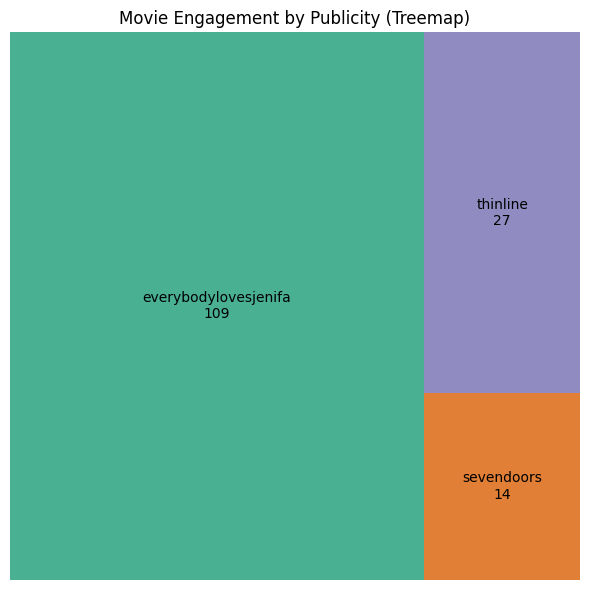

In [30]:
# Define top engagement drivers that can reasonably pertain to publicity rather than content
engagement_drivers_publicity_list = ["premiere", "cinemas"]
engagement_drivers_publicity = movies_to_analyse[movies_to_analyse['Tweet'].str.contains('|'.join(engagement_drivers_publicity_list), case=False)]

# Prepare data
engagement_driven_by_publicity = engagement_drivers_publicity.groupby('Movie').size()
sizes = engagement_driven_by_publicity.values
labels = [f"{movie}\n{count}" for movie, count in zip(engagement_driven_by_content.index, sizes)]
colors = sns.color_palette('Dark2', len(engagement_driven_by_publicity))

# Create the treemap
plt.figure(figsize=(6, 6))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)
plt.title('Movie Engagement by Publicity (Treemap)')

# Remove axes
plt.axis('off')

# Display the chart
plt.tight_layout()
plt.show()

### Analysis of Top Names/Discussions Relating to Each Movie

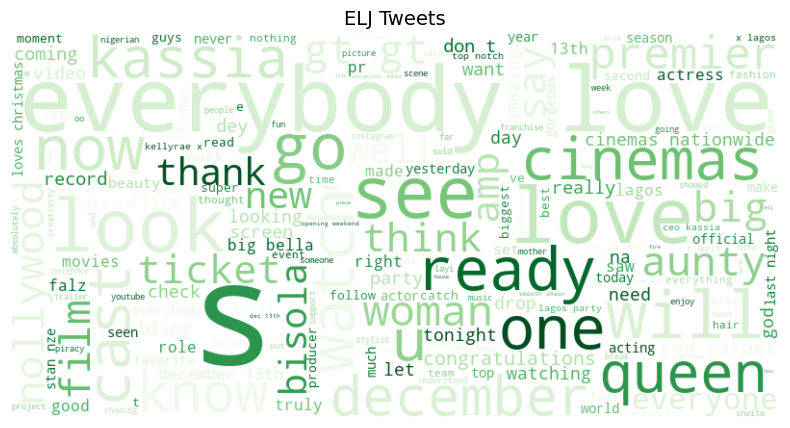

In [31]:
elj_tweets = processed_data.loc[processed_data['Movie'] == 'everybodylovesjenifa']

# Combine all tweets into one text
elj_wc_tweets = ' '.join(elj_tweets['Processed_Tweet'])

# Define custom stopwords (default + additional)
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["premiere", "cinema", "movie", "outfit", "beautiful", "jenifa", "funke", "akindele",  "everybody loves jenifa", "everybodylovesjenifa"])

# Generate word cloud excluding stopwords
elj_wc = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='Greens', 
    stopwords=custom_stopwords  # Pass custom stopwords
).generate(elj_wc_tweets)

# Plot the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(elj_wc, interpolation='bilinear')
plt.title('ELJ Tweets', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

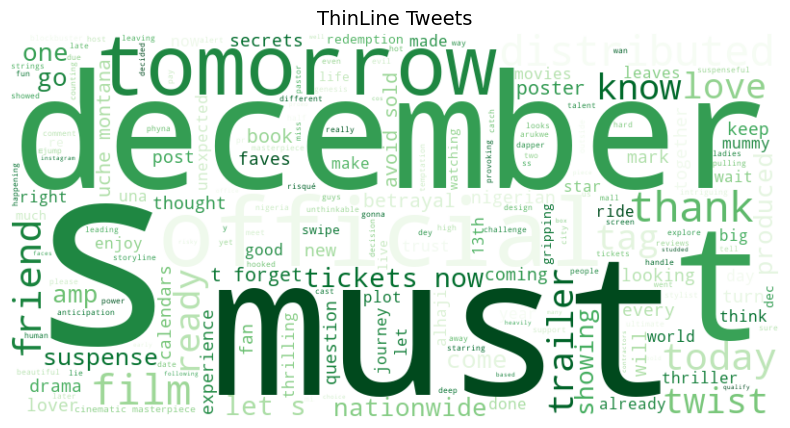

In [32]:
thinline_tweets = processed_data.loc[processed_data['Movie'] == 'thinline']

# Combine all tweets into one text
thinline_wc_tweets = ' '.join(thinline_tweets['Processed_Tweet'])

# Define custom stopwords (default + additional)
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["premiere", "cinemas", "cinema", "movie", "watch", "outfit", "thinline", "mercy", "aigbe", "adeoti", "thinlinethemovie", "thin line", "thin", "line", "see", "don"])

# Generate word cloud excluding stopwords
thinline_wc = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='Greens', 
    stopwords=custom_stopwords  # Pass custom stopwords
).generate(thinline_wc_tweets)

# Plot the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(thinline_wc, interpolation='bilinear')
plt.title('ThinLine Tweets', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

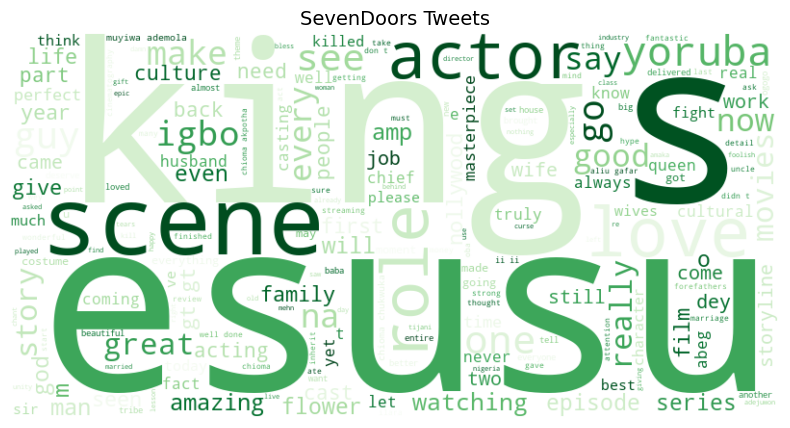

In [33]:
sevendoors_tweets = processed_data.loc[processed_data['Movie'] == 'sevendoors']

# Combine all tweets into one text
sevendoors_wc_tweets = ' '.join(sevendoors_tweets['Processed_Tweet'])

# Define custom stopwords (default + additional)
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["premiere", "cinemas", "watch", "movie", "seven doors", "sevendoors", "femi", "adebayo", "netflix", "doors", "seven"])

# Generate word cloud excluding stopwords
sevendoors_wc = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='Greens', 
    stopwords=custom_stopwords  # Pass custom stopwords
).generate(sevendoors_wc_tweets)

# Plot the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(sevendoors_wc, interpolation='bilinear')
plt.title('SevenDoors Tweets', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

## Sentiment Analysis using VADER

In [34]:
movies_vader = processed_data.copy()
movies_vader.head(2)

,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie,Processed_Tweet
1,2,After singing “ my husband does not have a concubine” only for your husband to marry 6 more wives 😭😭😂😂\nI knew something would happen after she sang that song \n#SevenDoors https://t.co/he4Bx81T4X,[sevendoors],0,2,2024-12-17,sevendoors,after singing “ my husband does not have a concubine” only for your husband to marry 6 more wives \ni knew something would happen after she sang that song \n
2,3,I feel Kolawole Ajeyemi should be getting more lead roles. #SevenDoors \n\nThere is so much more in him that has not been harnessed. https://t.co/07CzfG2rIp,[sevendoors],497,5410,2024-12-15,sevendoors,i feel kolawole ajeyemi should be getting more lead roles. \n\nthere is so much more in him that has not been harnessed.


In [35]:
# Initialize the sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis
def analyze_sentiment(text):
    # Get the sentiment scores
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']

def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to the 'Processed_Tweet' column
movies_vader['Sentiment'] = movies_vader['Processed_Tweet'].apply(analyze_sentiment)

# Apply the categorization
movies_vader['Sentiment_Category'] = movies_vader['Sentiment'].apply(sentiment_category)

movies_vader.head(10)

,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie,Processed_Tweet,Sentiment,Sentiment_Category
1,2,After singing “ my husband does not have a concubine” only for your husband to marry 6 more wives 😭😭😂😂\nI knew something would happen after she sang that song \n#SevenDoors https://t.co/he4Bx81T4X,[sevendoors],0,2,2024-12-17,sevendoors,after singing “ my husband does not have a concubine” only for your husband to marry 6 more wives \ni knew something would happen after she sang that song \n,0.0000,Neutral
2,3,I feel Kolawole Ajeyemi should be getting more lead roles. #SevenDoors \n\nThere is so much more in him that has not been harnessed. https://t.co/07CzfG2rIp,[sevendoors],497,5410,2024-12-15,sevendoors,i feel kolawole ajeyemi should be getting more lead roles. \n\nthere is so much more in him that has not been harnessed.,0.0000,Neutral
3,4,"It's the fact that Esusu was minding his business when they went to find him. He had accepted his faith as an outcast, but they returned him back to society. You asked for a long life and he gave it to you.\n\nHe was cheated 😒\n\n#SevenDoorsOnNetflix https://t.co/pCCQKJXTuv",[sevendoorsonnetflix],3,13,2024-12-16,sevendoors,"it's the fact that esusu was minding his business when they went to find him. he had accepted his faith as an outcast, but they returned him back to society. you asked for a long life and he gave it to you.\n\nhe was cheated \n\n",-0.4588,Negative
4,5,Hakeem effect did this on #SevenDoors. He is too good in this SFX makeup.\n#SevenDoorsOnNetflix https://t.co/0U3tw5cXZM,"[sevendoors, sevendoorsonnetflix]",7,110,2024-12-16,sevendoors,hakeem effect did this on he is too good in this sfx makeup.\n,0.4404,Positive
5,6,"Yoruba sweet abeg 😍 🤣 😂 \nIf you understand this, heaven no sure for you🫴😂😂\n\n#SevenDoors \n#SevenDoorsOnNetflix https://t.co/IU36EhXeST","[sevendoors, sevendoorsonnetflix]",1,5,2024-12-15,sevendoors,"yoruba sweet abeg \nif you understand this, heaven no sure for you\n\n \n",0.7107,Positive
6,7,"Meet Aliu Gafar the man behind the role of “Esusu” on Seven doors by Femi Adebayo\n\nHis acting skills is on a whole nother level , he deserves an award for that role #SevenDoorsOnNetflix https://t.co/BTfh0owvvq",[sevendoorsonnetflix],29,444,2024-12-15,sevendoors,"meet aliu gafar the man behind the role of “esusu” on seven doors by femi adebayo\n\nhis acting skills is on a whole nother level , he deserves an award for that role",0.5423,Positive
7,8,The way Muyiwa Ademoka played ans delivered his role on SEVEN DOORS is so underappreciated.\nHe is such a good actor and he deserves his flowers. \n #SevenDoorsOnNetflix https://t.co/ngbP1Ns1sq,[sevendoorsonnetflix],1,8,2024-12-17,sevendoors,the way muyiwa ademoka played ans delivered his role on seven doors is so underappreciated.\nhe is such a good actor and he deserves his flowers. \n,0.6486,Positive
8,9,Just one scene and you pkai half of the village. What if na you be esusu ? 😂😂😂 \n@YemiElesho4 \n #SevenDoorsOnNetflix https://t.co/QJDV3JvW6C,[sevendoorsonnetflix],161,1171,2024-12-15,sevendoors,just one scene and you pkai half of the village. what if na you be esusu ? \n \n,0.0000,Neutral
9,10,"If na Muyiwa Ademola become king, e for just ask Esusu make e paste Aza , all these fighting no necessary 😂🤣 #SevenDoorsOnNetflix #SevenDoors https://t.co/Yu2ddsiz8J","[sevendoorsonnetflix, sevendoors]",227,1621,2024-12-13,sevendoors,"if na muyiwa ademola become king, e for just ask esusu make e paste aza , all these fighting no necessary",-0.5719,Negative
10,11,"Just one scene, he killed the entire village...😂😂😂\n\n#SevenDoorsOnNetflix\n\nhttps://t.co/NEIh9EOQ8D",[sevendoorsonnetflix],2,22,2024-12-15,sevendoors,"just one scene, he killed the entire village...\n\n\n\n",-0.6705,Negative


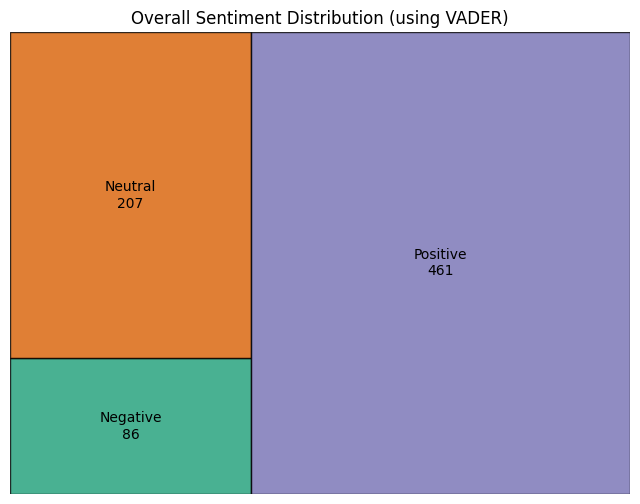

In [36]:
overall_sentiment_vader = movies_vader.groupby('Sentiment_Category').size()

# Prepare data for the treemap
sizes_vader = overall_sentiment_vader.values
labels_vader = [f"{cat}\n{count}" for cat, count in zip(overall_sentiment_vader.index, overall_sentiment_vader.values)]

# Plot the treemap
plt.figure(figsize=(8, 6))
colors = sns.color_palette('Dark2', len(overall_sentiment_vader))

squarify.plot(sizes=sizes_vader, label=labels_vader, color=colors, alpha=0.8, edgecolor='black')
plt.title('Overall Sentiment Distribution (using VADER)')
plt.axis('off')  # Remove axes

# Display the plot
plt.show()

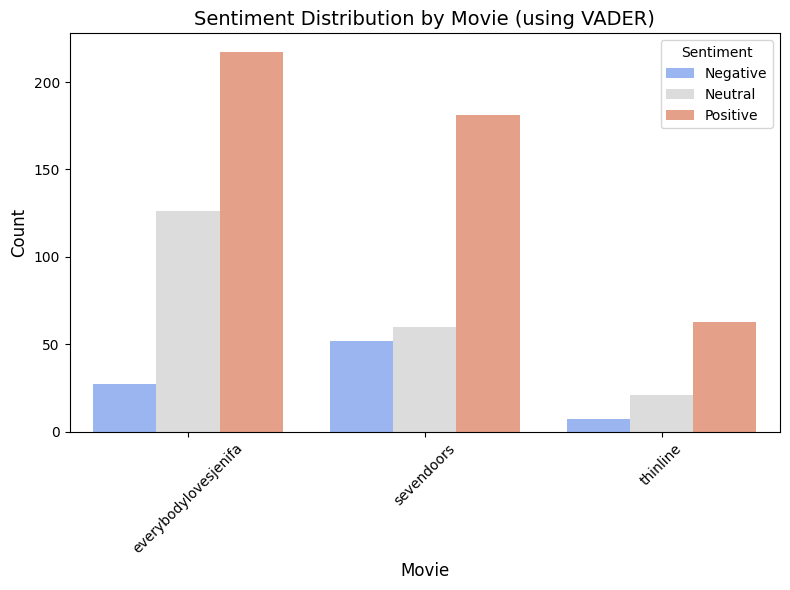

In [37]:
# Group by movie and sentiment category
sentiment_counts = movies_vader.groupby(['Movie', 'Sentiment_Category']).size().reset_index(name='Count')

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Movie', y='Count', hue='Sentiment_Category', data=sentiment_counts, palette='coolwarm')
plt.title('Sentiment Distribution by Movie (using VADER)', fontsize=14)
plt.xlabel('Movie', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Sentiment', fontsize=10)
plt.tight_layout()
plt.show()

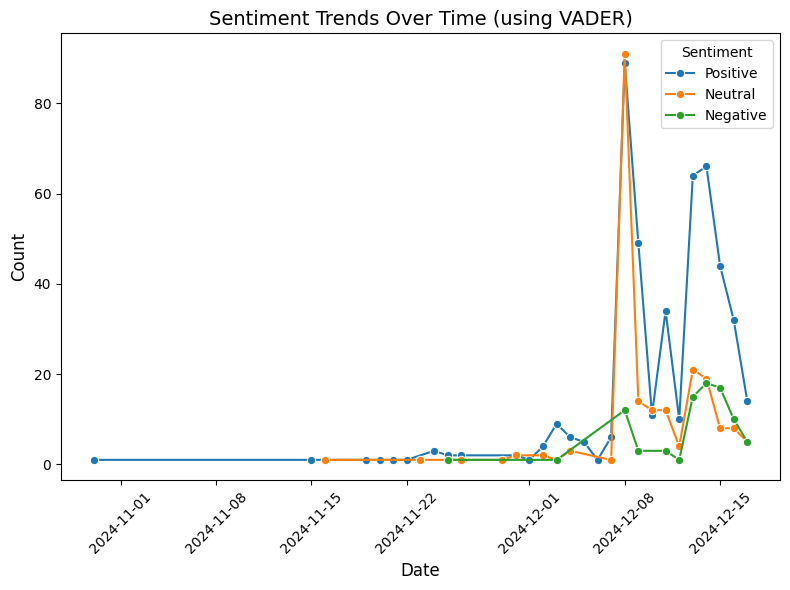

In [38]:
# Group by date and sentiment
sentiment_trends_vader = movies_vader.groupby(['Date', 'Sentiment_Category']).size().reset_index(name='Count')

# Create a line plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=sentiment_trends_vader, x='Date', y='Count', hue='Sentiment_Category', marker='o')
plt.title('Sentiment Trends Over Time (using VADER)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Sentiment', fontsize=10)
plt.tight_layout()
plt.show()

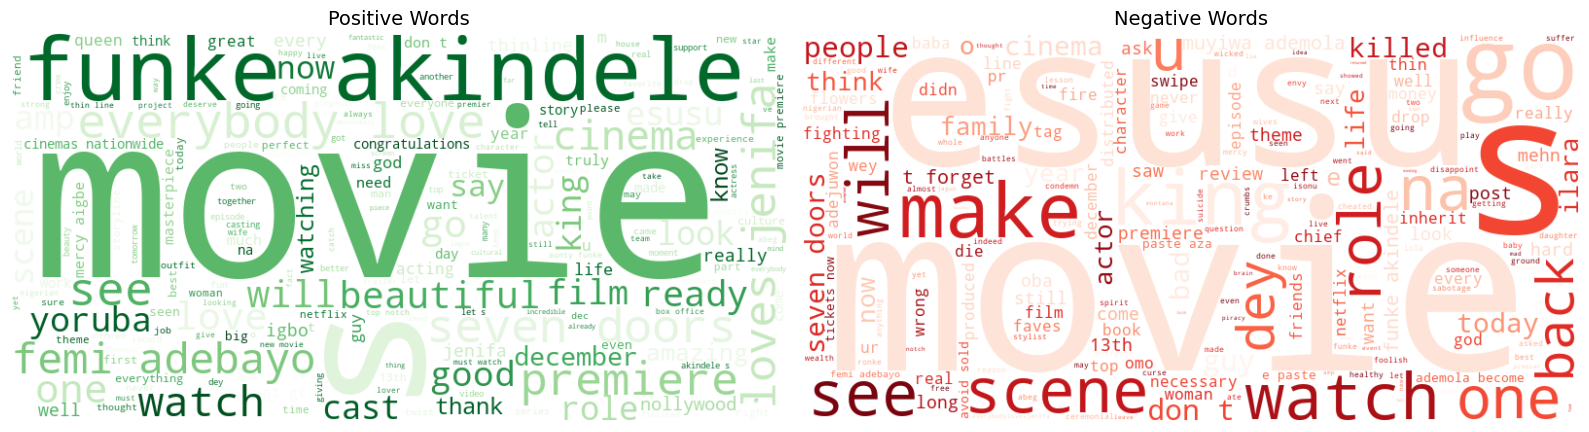

In [39]:
# Filter tweets by sentiment
positive_tweets_vader = ' '.join(movies_vader[movies_vader['Sentiment_Category'] == 'Positive']['Processed_Tweet'])
negative_tweets_vader = ' '.join(movies_vader[movies_vader['Sentiment_Category'] == 'Negative']['Processed_Tweet'])

custom_stopwords = set(STOPWORDS)

# Generate word clouds
positive_wc_vader = WordCloud(width=800, height=400, background_color='white', colormap='Greens', stopwords=custom_stopwords).generate(positive_tweets_vader)
negative_wc_vader = WordCloud(width=800, height=400, background_color='white', colormap='Reds', stopwords=custom_stopwords).generate(negative_tweets_vader)

# Plot word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc_vader, interpolation='bilinear')
plt.title('Positive Words', fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc_vader, interpolation='bilinear')
plt.title('Negative Words', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

## Sentiment Analysis using RoBERTa

In [40]:
movies_roberta = processed_data.copy()
movies_roberta.head(2)

,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie,Processed_Tweet
1,2,After singing “ my husband does not have a concubine” only for your husband to marry 6 more wives 😭😭😂😂\nI knew something would happen after she sang that song \n#SevenDoors https://t.co/he4Bx81T4X,[sevendoors],0,2,2024-12-17,sevendoors,after singing “ my husband does not have a concubine” only for your husband to marry 6 more wives \ni knew something would happen after she sang that song \n
2,3,I feel Kolawole Ajeyemi should be getting more lead roles. #SevenDoors \n\nThere is so much more in him that has not been harnessed. https://t.co/07CzfG2rIp,[sevendoors],497,5410,2024-12-15,sevendoors,i feel kolawole ajeyemi should be getting more lead roles. \n\nthere is so much more in him that has not been harnessed.


In [41]:
roberta = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

# Function to tokenize text and get predictions
def get_sentiment(text):
    # Tokenize the tweet text
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)
    
    # Get raw scores and apply softmax
    scores = outputs[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

movies_roberta['Sentiment'] = movies_roberta['Processed_Tweet'].apply(get_sentiment)

# Display the first few rows
movies_roberta.head()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie,Processed_Tweet,Sentiment
1,2,After singing “ my husband does not have a concubine” only for your husband to marry 6 more wives 😭😭😂😂\nI knew something would happen after she sang that song \n#SevenDoors https://t.co/he4Bx81T4X,[sevendoors],0,2,2024-12-17,sevendoors,after singing “ my husband does not have a concubine” only for your husband to marry 6 more wives \ni knew something would happen after she sang that song \n,"[0.53602153, 0.43318066, 0.030797767]"
2,3,I feel Kolawole Ajeyemi should be getting more lead roles. #SevenDoors \n\nThere is so much more in him that has not been harnessed. https://t.co/07CzfG2rIp,[sevendoors],497,5410,2024-12-15,sevendoors,i feel kolawole ajeyemi should be getting more lead roles. \n\nthere is so much more in him that has not been harnessed.,"[0.11140036, 0.3830542, 0.5055455]"
3,4,"It's the fact that Esusu was minding his business when they went to find him. He had accepted his faith as an outcast, but they returned him back to society. You asked for a long life and he gave it to you.\n\nHe was cheated 😒\n\n#SevenDoorsOnNetflix https://t.co/pCCQKJXTuv",[sevendoorsonnetflix],3,13,2024-12-16,sevendoors,"it's the fact that esusu was minding his business when they went to find him. he had accepted his faith as an outcast, but they returned him back to society. you asked for a long life and he gave it to you.\n\nhe was cheated \n\n","[0.3639451, 0.5891181, 0.046936754]"
4,5,Hakeem effect did this on #SevenDoors. He is too good in this SFX makeup.\n#SevenDoorsOnNetflix https://t.co/0U3tw5cXZM,"[sevendoors, sevendoorsonnetflix]",7,110,2024-12-16,sevendoors,hakeem effect did this on he is too good in this sfx makeup.\n,"[0.015838591, 0.092098735, 0.8920627]"
5,6,"Yoruba sweet abeg 😍 🤣 😂 \nIf you understand this, heaven no sure for you🫴😂😂\n\n#SevenDoors \n#SevenDoorsOnNetflix https://t.co/IU36EhXeST","[sevendoors, sevendoorsonnetflix]",1,5,2024-12-15,sevendoors,"yoruba sweet abeg \nif you understand this, heaven no sure for you\n\n \n","[0.15847628, 0.46020415, 0.38131952]"


In [42]:
# Define weights for sentiment categories: Negative, Neutral, Positive
weights = np.array([-1, 0, 1])

# Function to calculate weighted sentiment score
def calculate_overall_sentiment(row):
    """
    Calculates a weighted sentiment score for the row using predefined weights.
    """
    scores = np.array(row)
    overall_score = np.dot(scores, weights)
    return overall_score

def sentiment_category(overall_score):
    if overall_score >= 0.05:
        return 'Positive'
    elif overall_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the 'Sentiment_Scores' column
movies_roberta['Overall_Sentiment'] = movies_roberta['Sentiment'].apply(calculate_overall_sentiment)

# Apply the function to the 'Overall_Sentiment' column to get Sentiment_Category
movies_roberta['Sentiment_Category'] = movies_roberta['Overall_Sentiment'].apply(sentiment_category)

movies_roberta.head(10)

,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie,Processed_Tweet,Sentiment,Overall_Sentiment,Sentiment_Category
1,2,After singing “ my husband does not have a concubine” only for your husband to marry 6 more wives 😭😭😂😂\nI knew something would happen after she sang that song \n#SevenDoors https://t.co/he4Bx81T4X,[sevendoors],0,2,2024-12-17,sevendoors,after singing “ my husband does not have a concubine” only for your husband to marry 6 more wives \ni knew something would happen after she sang that song \n,"[0.53602153, 0.43318066, 0.030797767]",-0.505224,Negative
2,3,I feel Kolawole Ajeyemi should be getting more lead roles. #SevenDoors \n\nThere is so much more in him that has not been harnessed. https://t.co/07CzfG2rIp,[sevendoors],497,5410,2024-12-15,sevendoors,i feel kolawole ajeyemi should be getting more lead roles. \n\nthere is so much more in him that has not been harnessed.,"[0.11140036, 0.3830542, 0.5055455]",0.394145,Positive
3,4,"It's the fact that Esusu was minding his business when they went to find him. He had accepted his faith as an outcast, but they returned him back to society. You asked for a long life and he gave it to you.\n\nHe was cheated 😒\n\n#SevenDoorsOnNetflix https://t.co/pCCQKJXTuv",[sevendoorsonnetflix],3,13,2024-12-16,sevendoors,"it's the fact that esusu was minding his business when they went to find him. he had accepted his faith as an outcast, but they returned him back to society. you asked for a long life and he gave it to you.\n\nhe was cheated \n\n","[0.3639451, 0.5891181, 0.046936754]",-0.317008,Negative
4,5,Hakeem effect did this on #SevenDoors. He is too good in this SFX makeup.\n#SevenDoorsOnNetflix https://t.co/0U3tw5cXZM,"[sevendoors, sevendoorsonnetflix]",7,110,2024-12-16,sevendoors,hakeem effect did this on he is too good in this sfx makeup.\n,"[0.015838591, 0.092098735, 0.8920627]",0.876224,Positive
5,6,"Yoruba sweet abeg 😍 🤣 😂 \nIf you understand this, heaven no sure for you🫴😂😂\n\n#SevenDoors \n#SevenDoorsOnNetflix https://t.co/IU36EhXeST","[sevendoors, sevendoorsonnetflix]",1,5,2024-12-15,sevendoors,"yoruba sweet abeg \nif you understand this, heaven no sure for you\n\n \n","[0.15847628, 0.46020415, 0.38131952]",0.222843,Positive
6,7,"Meet Aliu Gafar the man behind the role of “Esusu” on Seven doors by Femi Adebayo\n\nHis acting skills is on a whole nother level , he deserves an award for that role #SevenDoorsOnNetflix https://t.co/BTfh0owvvq",[sevendoorsonnetflix],29,444,2024-12-15,sevendoors,"meet aliu gafar the man behind the role of “esusu” on seven doors by femi adebayo\n\nhis acting skills is on a whole nother level , he deserves an award for that role","[0.009127615, 0.10301299, 0.88785934]",0.878732,Positive
7,8,The way Muyiwa Ademoka played ans delivered his role on SEVEN DOORS is so underappreciated.\nHe is such a good actor and he deserves his flowers. \n #SevenDoorsOnNetflix https://t.co/ngbP1Ns1sq,[sevendoorsonnetflix],1,8,2024-12-17,sevendoors,the way muyiwa ademoka played ans delivered his role on seven doors is so underappreciated.\nhe is such a good actor and he deserves his flowers. \n,"[0.014003883, 0.042430766, 0.9435653]",0.929561,Positive
8,9,Just one scene and you pkai half of the village. What if na you be esusu ? 😂😂😂 \n@YemiElesho4 \n #SevenDoorsOnNetflix https://t.co/QJDV3JvW6C,[sevendoorsonnetflix],161,1171,2024-12-15,sevendoors,just one scene and you pkai half of the village. what if na you be esusu ? \n \n,"[0.14248173, 0.7978566, 0.059661634]",-0.082820,Negative
9,10,"If na Muyiwa Ademola become king, e for just ask Esusu make e paste Aza , all these fighting no necessary 😂🤣 #SevenDoorsOnNetflix #SevenDoors https://t.co/Yu2ddsiz8J","[sevendoorsonnetflix, sevendoors]",227,1621,2024-12-13,sevendoors,"if na muyiwa ademola become king, e for just ask esusu make e paste aza , all these fighting no necessary","[0.25212756, 0.677365, 0.07050746]",-0.181620,Negative
10,11,"Just one scene, he killed the entire village...😂😂😂\n\n#SevenDoorsOnNetflix\n\nht

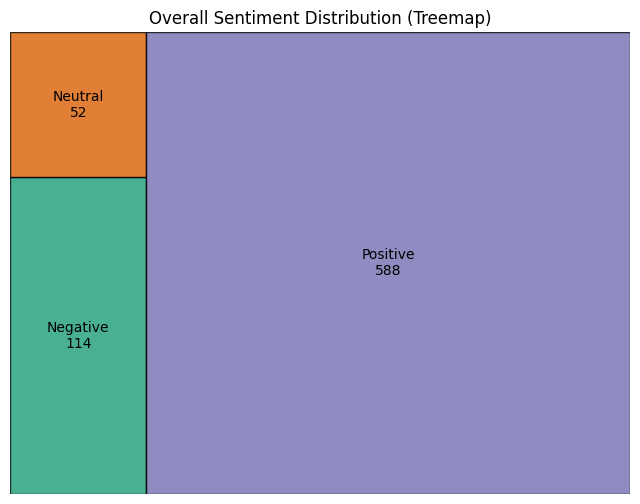

In [43]:
overall_sentiment_roberta = movies_roberta.groupby('Sentiment_Category').size()

# Prepare data for the treemap
sizes = overall_sentiment_roberta.values
labels = [f"{cat}\n{count}" for cat, count in zip(overall_sentiment_roberta.index, overall_sentiment_roberta.values)]

# Plot the treemap
plt.figure(figsize=(8, 6))
colors = sns.color_palette('Dark2', len(overall_sentiment_roberta))

squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, edgecolor='black')
plt.title('Overall Sentiment Distribution (Treemap)')
plt.axis('off')  # Remove axes

# Display the plot
plt.show()

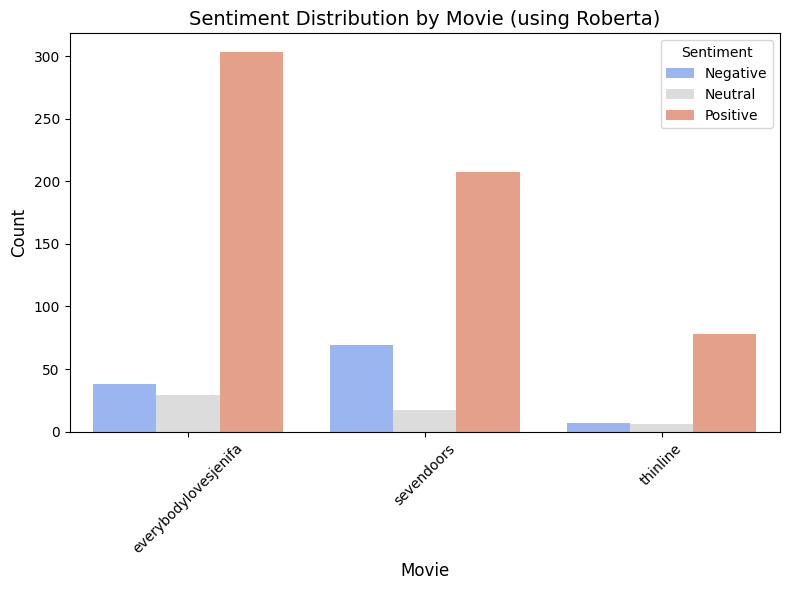

In [44]:
# Group by movie and sentiment category
sentiment_by_movie_roberta = movies_roberta.groupby(['Movie', 'Sentiment_Category']).size().reset_index(name='Count')

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Movie', y='Count', hue='Sentiment_Category', data=sentiment_by_movie_roberta, palette='coolwarm')
plt.title('Sentiment Distribution by Movie (using Roberta)', fontsize=14)
plt.xlabel('Movie', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Sentiment', fontsize=10)
plt.tight_layout()
plt.show()

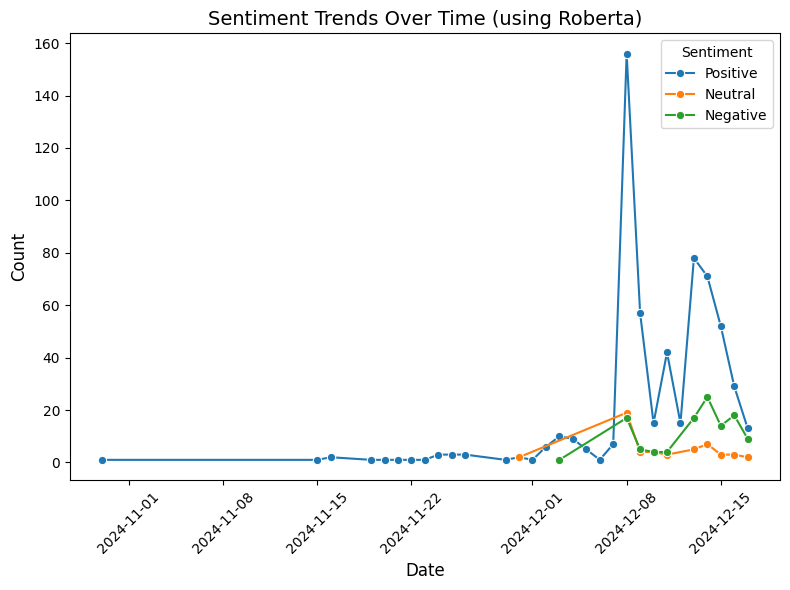

In [45]:
# Group by date and sentiment
sentiment_trends_roberta = movies_roberta.groupby(['Date', 'Sentiment_Category']).size().reset_index(name='Count')

# Create a line plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=sentiment_trends_roberta, x='Date', y='Count', hue='Sentiment_Category', marker='o')
plt.title('Sentiment Trends Over Time (using Roberta)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Sentiment', fontsize=10)
plt.tight_layout()
plt.show()

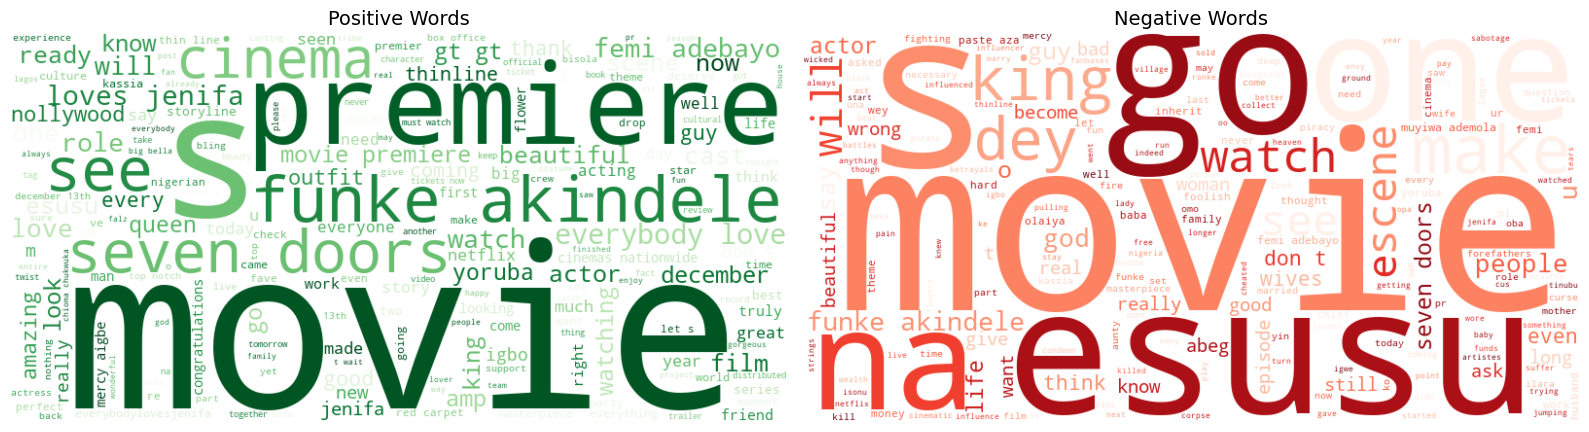

In [46]:
# Filter tweets by sentiment
positive_tweets_roberta = ' '.join(movies_roberta[movies_roberta['Sentiment_Category'] == 'Positive']['Processed_Tweet'])
negative_tweets_roberta = ' '.join(movies_roberta[movies_roberta['Sentiment_Category'] == 'Negative']['Processed_Tweet'])

custom_stopwords = set(STOPWORDS)

# Generate word clouds
positive_wc_roberta = WordCloud(width=800, height=400, background_color='white', colormap='Greens', stopwords=custom_stopwords).generate(positive_tweets_roberta)
negative_wc_roberta = WordCloud(width=800, height=400, background_color='white', colormap='Reds', stopwords=custom_stopwords).generate(negative_tweets_roberta)

# Plot word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc_roberta, interpolation='bilinear')
plt.title('Positive Words', fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc_roberta, interpolation='bilinear')
plt.title('Negative Words', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

#### Emotion Analysis using Ekman

In [47]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm

emotion_analysis_data = processed_data.copy()

# Initialize the Ekman sentiment analysis model
ekman = pipeline('sentiment-analysis', model='arpanghoshal/EkmanClassifier')

# Define the analysis column
target_column = 'Processed_Tweet'

# Use tqdm for progress tracking (optional)
tqdm.pandas()

# Apply the model to the target column and extract the label
emotion_analysis_data['Emotion'] = emotion_analysis_data[target_column].progress_apply(lambda text: ekman(text)[0]['label'])
emotion_analysis_data.head(10)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0
100%|██████████| 754/754 [00:21<00:00, 34.31it/s]


,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie,Processed_Tweet,Emotion
1,2,After singing “ my husband does not have a concubine” only for your husband to marry 6 more wives 😭😭😂😂\nI knew something would happen after she sang that song \n#SevenDoors https://t.co/he4Bx81T4X,[sevendoors],0,2,2024-12-17,sevendoors,after singing “ my husband does not have a concubine” only for your husband to marry 6 more wives \ni knew something would happen after she sang that song \n,neutral
2,3,I feel Kolawole Ajeyemi should be getting more lead roles. #SevenDoors \n\nThere is so much more in him that has not been harnessed. https://t.co/07CzfG2rIp,[sevendoors],497,5410,2024-12-15,sevendoors,i feel kolawole ajeyemi should be getting more lead roles. \n\nthere is so much more in him that has not been harnessed.,neutral
3,4,"It's the fact that Esusu was minding his business when they went to find him. He had accepted his faith as an outcast, but they returned him back to society. You asked for a long life and he gave it to you.\n\nHe was cheated 😒\n\n#SevenDoorsOnNetflix https://t.co/pCCQKJXTuv",[sevendoorsonnetflix],3,13,2024-12-16,sevendoors,"it's the fact that esusu was minding his business when they went to find him. he had accepted his faith as an outcast, but they returned him back to society. you asked for a long life and he gave it to you.\n\nhe was cheated \n\n",neutral
4,5,Hakeem effect did this on #SevenDoors. He is too good in this SFX makeup.\n#SevenDoorsOnNetflix https://t.co/0U3tw5cXZM,"[sevendoors, sevendoorsonnetflix]",7,110,2024-12-16,sevendoors,hakeem effect did this on he is too good in this sfx makeup.\n,joy
5,6,"Yoruba sweet abeg 😍 🤣 😂 \nIf you understand this, heaven no sure for you🫴😂😂\n\n#SevenDoors \n#SevenDoorsOnNetflix https://t.co/IU36EhXeST","[sevendoors, sevendoorsonnetflix]",1,5,2024-12-15,sevendoors,"yoruba sweet abeg \nif you understand this, heaven no sure for you\n\n \n",surprise
6,7,"Meet Aliu Gafar the man behind the role of “Esusu” on Seven doors by Femi Adebayo\n\nHis acting skills is on a whole nother level , he deserves an award for that role #SevenDoorsOnNetflix https://t.co/BTfh0owvvq",[sevendoorsonnetflix],29,444,2024-12-15,sevendoors,"meet aliu gafar the man behind the role of “esusu” on seven doors by femi adebayo\n\nhis acting skills is on a whole nother level , he deserves an award for that role",neutral
7,8,The way Muyiwa Ademoka played ans delivered his role on SEVEN DOORS is so underappreciated.\nHe is such a good actor and he deserves his flowers. \n #SevenDoorsOnNetflix https://t.co/ngbP1Ns1sq,[sevendoorsonnetflix],1,8,2024-12-17,sevendoors,the way muyiwa ademoka played ans delivered his role on seven doors is so underappreciated.\nhe is such a good actor and he deserves his flowers. \n,joy
8,9,Just one scene and you pkai half of the village. What if na you be esusu ? 😂😂😂 \n@YemiElesho4 \n #SevenDoorsOnNetflix https://t.co/QJDV3JvW6C,[sevendoorsonnetflix],161,1171,2024-12-15,sevendoors,just one scene and you pkai half of the village. what if na you be esusu ? \n \n,neutral
9,10,"If na Muyiwa Ademola become king, e for just ask Esusu make e paste Aza , all these fighting no necessary 😂🤣 #SevenDoorsOnNetflix #SevenDoors https://t.co/Yu2ddsiz8J","[sevendoorsonnetflix, sevendoors]",227,1621,2024-12-13,sevendoors,"if na muyiwa ademola become king, e for just ask esusu make e paste aza , all these fighting no necessary",neutral
10,11,"Just one scene, he killed the entire village...😂😂😂\n\n#SevenDoorsOnNetflix\n\nhttps://t.co/NEIh9EOQ8D",[sevendoorsonnetflix],2,22,2024-12-15,sevendoors,"just one scene, he killed the entire village...\n\n\n\n",neutral


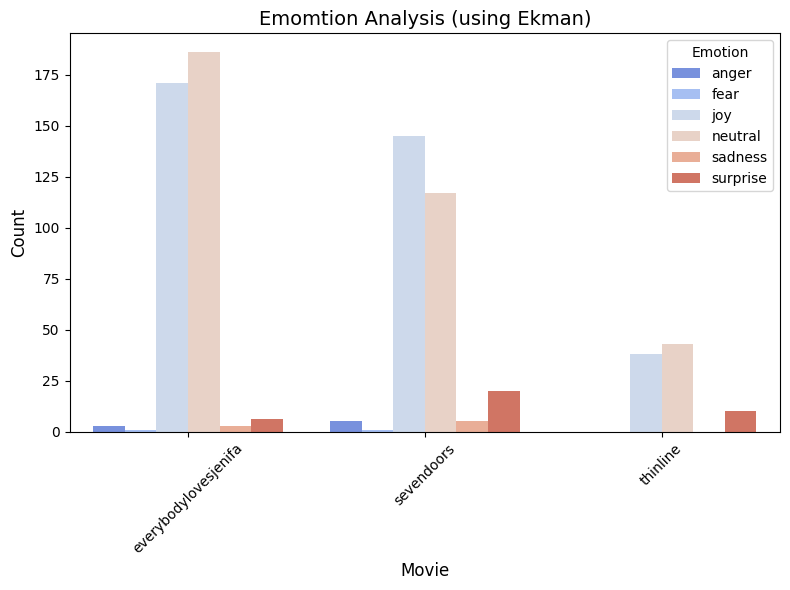

In [48]:
# Group by movie and emotion
emotion_analysis = emotion_analysis_data.groupby(['Movie', 'Emotion']).size().reset_index(name='Count')

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Movie', y='Count', hue='Emotion', data=emotion_analysis, palette='coolwarm')
plt.title('Emomtion Analysis (using Ekman)', fontsize=14)
plt.xlabel('Movie', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Emotion', fontsize=10)
plt.tight_layout()
plt.show()

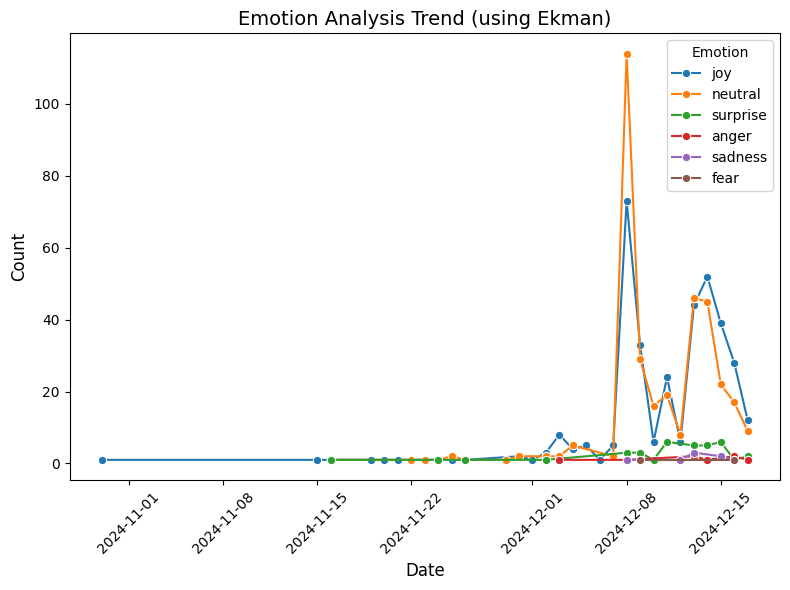

In [49]:
# Group by date and emotion
emotion_analysis_trend = emotion_analysis_data.groupby(['Date', 'Emotion']).size().reset_index(name='Count')

# Create a line plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=emotion_analysis_trend, x='Date', y='Count', hue='Emotion', marker='o')
plt.title('Emotion Analysis Trend (using Ekman)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Emotion', fontsize=10)
plt.tight_layout()
plt.show()

### Comparison of Sentiment Analysis Models

In [50]:
review_vader = movies_vader.loc[movies_vader['Tweet_count'].isin([782, 216, 14, 283, 117, 768, 134, 850, 733, 913])]
review_vader

,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie,Processed_Tweet,Sentiment,Sentiment_Category
13,14,"Aliu Gafar delivers stellar performance as Esusu in Femi Adebayo's Seven Doors \n\n(#SevenDoors, #SevenDoorsOnNetflix)\n\nBy Victor Ojelabi\n\nThe much-anticipated movie series Seven Doors by Femi Adebayo has finally premiered, currently showing on Netflix, captivating audiences with https://t.co/LWZZrbwfrd","[sevendoors, sevendoorsonnetflix]",4,18,2024-12-13,sevendoors,"aliu gafar delivers stellar performance as esusu in femi adebayo's seven doors \n\n( \n\nby victor ojelabi\n\nthe much-anticipated movie series seven doors by femi adebayo has finally premiered, currently showing on netflix, captivating audiences with",0.0,Neutral
116,117,Chief Otun and his wife 😂 #SevenDoorsOnNetflix https://t.co/IU9JQoWgOW,[sevendoorsonnetflix],0,6,2024-12-16,sevendoors,chief otun and his wife,0.0,Neutral
133,134,The vlog and review at the end 🫶\n\n#everybodylovesjenifa https://t.co/smsBcfekBk,[everybodylovesjenifa],1,18,2024-12-14,everybodylovesjenifa,the vlog and review at the end \n\n,0.0,Neutral
215,216,🟢⚡️PHOTOS: Some of the Cast of the at the cultural premiere of seven doors series coming to Netflix\n\n#SevenDoorsThePremiere\n#SevenDoorsOnNetflix https://t.co/N6kSRycPqd,"[sevendoorsthepremiere, sevendoorsonnetflix]",3,8,2024-12-12,sevendoors,🟢photos: some of the cast of the at the cultural premiere of seven doors series coming to netflix\n\n\n,0.0,Neutral
282,283,At this point Africans living abroad need to petition Netflix 😭😭😭😭😭#SevenDoors #SevenDoorsOnNetflix.,"[sevendoors, sevendoorsonnetflix]",0,4,2024-12-13,sevendoors,at this point africans living abroad need to petition netflix,0.0,Neutral
732,733,Outfit of Hilda Baci for Premiere of #EverybodyLovesJenifa https://t.co/uZTtBaFQpZ,[everybodylovesjenifa],1,14,2024-12-08,everybodylovesjenifa,outfit of hilda baci for premiere of,0.0,Neutral
767,768,Yemi Cregx at the #EverybodyLovesJenifa premiere 🥹🥹🙂‍↔️🙂‍↔️ #Yemicregx https://t.co/ZBtQSuZT9b,"[everybodylovesjenifa, yemicregx]",1,56,2024-12-09,everybodylovesjenifa,yemi cregx at the premiere ‍↔‍↔,0.0,Neutral
781,782,"If you see Funke Akindele, you will know #EverybodyLovesJenifa 💯🎶🌍",[everybodylovesjenifa],1,2,2024-12-09,everybodylovesjenifa,"if you see funke akindele, you will know",0.0,Neutral
849,850,Kasilolo looking so exquisite 😍 \n#EverybodyLovesJenifa\n\nBIG KELLYRAE \nBUY RETIFY FOR GLOW\n#KellyraeforNXT\n\nBIG KASSIA\n#KassiaSule,"[everybodylovesjenifa, kellyraefornxt, kassiasule]",6,9,2024-12-08,everybodylovesjenifa,kasilolo looking so exquisite \n\n\nbig kellyrae \nbuy retify for glow\n\n\nbig kassia\n,0.0,Neutral
912,913,Official Lolo\n#EverybodyLovesJenifa https://t.co/vkXCsE0TDl,[everybodylovesjenifa],3,38,2024-12-08,everybodylovesjenifa,official lolo\n,0.0,Neutral


In [51]:
review_roberta = movies_roberta[movies_roberta['Tweet_count'].isin([782, 216, 14, 283, 117, 768, 134, 850, 733, 913])]
review_roberta = review_roberta[['Tweet_count', 'Tweet', 'Hashtags', 'Retweets', 'Likes', 'Date', 'Movie', 'Processed_Tweet', 'Overall_Sentiment', 'Sentiment_Category']]
review_roberta

,Tweet_count,Tweet,Hashtags,Retweets,Likes,Date,Movie,Processed_Tweet,Overall_Sentiment,Sentiment_Category
13,14,"Aliu Gafar delivers stellar performance as Esusu in Femi Adebayo's Seven Doors \n\n(#SevenDoors, #SevenDoorsOnNetflix)\n\nBy Victor Ojelabi\n\nThe much-anticipated movie series Seven Doors by Femi Adebayo has finally premiered, currently showing on Netflix, captivating audiences with https://t.co/LWZZrbwfrd","[sevendoors, sevendoorsonnetflix]",4,18,2024-12-13,sevendoors,"aliu gafar delivers stellar performance as esusu in femi adebayo's seven doors \n\n( \n\nby victor ojelabi\n\nthe much-anticipated movie series seven doors by femi adebayo has finally premiered, currently showing on netflix, captivating audiences with",0.919706,Positive
116,117,Chief Otun and his wife 😂 #SevenDoorsOnNetflix https://t.co/IU9JQoWgOW,[sevendoorsonnetflix],0,6,2024-12-16,sevendoors,chief otun and his wife,-0.066120,Negative
133,134,The vlog and review at the end 🫶\n\n#everybodylovesjenifa https://t.co/smsBcfekBk,[everybodylovesjenifa],1,18,2024-12-14,everybodylovesjenifa,the vlog and review at the end \n\n,0.114795,Positive
215,216,🟢⚡️PHOTOS: Some of the Cast of the at the cultural premiere of seven doors series coming to Netflix\n\n#SevenDoorsThePremiere\n#SevenDoorsOnNetflix https://t.co/N6kSRycPqd,"[sevendoorsthepremiere, sevendoorsonnetflix]",3,8,2024-12-12,sevendoors,🟢photos: some of the cast of the at the cultural premiere of seven doors series coming to netflix\n\n\n,0.087338,Positive
282,283,At this point Africans living abroad need to petition Netflix 😭😭😭😭😭#SevenDoors #SevenDoorsOnNetflix.,"[sevendoors, sevendoorsonnetflix]",0,4,2024-12-13,sevendoors,at this point africans living abroad need to petition netflix,-0.415532,Negative
732,733,Outfit of Hilda Baci for Premiere of #EverybodyLovesJenifa https://t.co/uZTtBaFQpZ,[everybodylovesjenifa],1,14,2024-12-08,everybodylovesjenifa,outfit of hilda baci for premiere of,0.065831,Positive
767,768,Yemi Cregx at the #EverybodyLovesJenifa premiere 🥹🥹🙂‍↔️🙂‍↔️ #Yemicregx https://t.co/ZBtQSuZT9b,"[everybodylovesjenifa, yemicregx]",1,56,2024-12-09,everybodylovesjenifa,yemi cregx at the premiere ‍↔‍↔,0.031311,Neutral
781,782,"If you see Funke Akindele, you will know #EverybodyLovesJenifa 💯🎶🌍",[everybodylovesjenifa],1,2,2024-12-09,everybodylovesjenifa,"if you see funke akindele, you will know",0.052201,Positive
849,850,Kasilolo looking so exquisite 😍 \n#EverybodyLovesJenifa\n\nBIG KELLYRAE \nBUY RETIFY FOR GLOW\n#KellyraeforNXT\n\nBIG KASSIA\n#KassiaSule,"[everybodylovesjenifa, kellyraefornxt, kassiasule]",6,9,2024-12-08,everybodylovesjenifa,kasilolo looking so exquisite \n\n\nbig kellyrae \nbuy retify for glow\n\n\nbig kassia\n,0.856226,Positive
912,913,Official Lolo\n#EverybodyLovesJenifa https://t.co/vkXCsE0TDl,[everybodylovesjenifa],3,38,2024-12-08,everybodylovesjenifa,official lolo\n,0.110380,Positive
